In [1]:
using DrWatson
@quickactivate "TriangularHubbard"

using DataStructures
using CodecXz
using SQLite
using DBInterface
using DataFrames
using Printf

using PyPlot
using PyCall
mpl = pyimport("matplotlib")

using LsqFit

  Activating project at `/data/pn1_1/klee/Projects/TriangularHubbard`


In [29]:
sns = pyimport("seaborn")
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

In [3]:
n_sites = 12
shape_str = "(2,-2)x(2,4)"
t = 1.0
U = 20.0

20.0

In [4]:
sectors_filepath = datadir("curie", shape_str, "sectors.sqlite3")
isfile(sectors_filepath)

true

SQLite.DB("/data/pn1_1/klee/Projects/TriangularHubbard/data/curie/(2,-2)x(2,4)/sectors.sqlite3")

In [22]:
# df = DataFrame(
#     DBInterface.execute(conn, """
#         SELECT temperature
#         FROM dense_results
#         INNER JOIN sectors
#         ON dense_results.idx = sectors.idx
#         WHERE hopping=? AND interaction=?
#         GROUP BY temperature
#     """, (t, U))
# )
# ;

In [9]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
df1 = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, temperature, partition
        FROM dense_results
        INNER JOIN sectors
        ON dense_results.idx = sectors.idx
        WHERE hopping=? AND interaction=?
    """, (t, U))
)
df2 = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, temperature, partition
        FROM sparse_results_collection
        INNER JOIN sectors
        ON sparse_results_collection.idx = sectors.idx
        WHERE hopping=? AND interaction=?
    """, (t, U))
)
DBInterface.close!(conn)
;

In [ ]:
df = vcat(df1, df2);

In [16]:
@show maximum(count(df[:, :temperature] .== T) for T in sort(unique(df[:, :temperature])))

maximum((count(df[:, :temperature] .== T) for T = sort(unique(df[:, :temperature])))) = 6412


6412

In [17]:
temperatures = Float64[]
for T in sort(unique(df[:, :temperature]))
    if count(df[:, :temperature] .== T) == 6412
        push!(temperatures, T)
    end
end
sort!(temperatures)
df = filter(row -> row.temperature ∈ temperatures, df)
;

In [33]:
df[:, :Sz] = 0.5*(df[:, :nup] - df[:, :ndn])
unique(sort(df[:, :Sz]))
n_list = unique(sort(df[:, :nup] .+ df[:, :ndn]))
;

In [34]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)

In [35]:
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"];


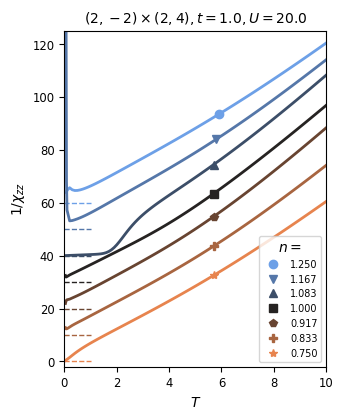

In [38]:
temperatures = unique(sort(df[:, :temperature]))
temperatures = [T for T in temperatures if T >= 0.04]
;

fig = PyPlot.figure(figsize=(3.4, 4))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

# n_list = [5,6,7,8,9,10,11,12,13]
# n_list = [9,10,11,12,13,14,15]
# n_list = n_sites-3:n_sites+3
n_list = n_sites+3:-1:n_sites-3

ymax = 0.0
for (idx, n) in enumerate(n_list)
    if n == 0 || n == 18
        continue
    end
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    yoffset = 10 * (length(n_list) - idx)
    ys = 1 ./ ys
    
    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys .+ yoffset,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    ax.plot(xs[60], ys[60] .+ yoffset, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
        color=color,
        alpha=1.0, markersize=6
    )
    ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
ax.set_ylim(-2, 125)
# ax.set_xscale("log")
# ax.set_yscale("log")

ax.legend(title=raw"$n=$", loc=4)
ax.set_xlabel(raw"$T$")
ax.set_ylabel(raw"$1/\chi_{zz}$")
#ax.set_title("$(shape_str), t=$t, U=$U")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), t=$t, U=$U\$")

fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)

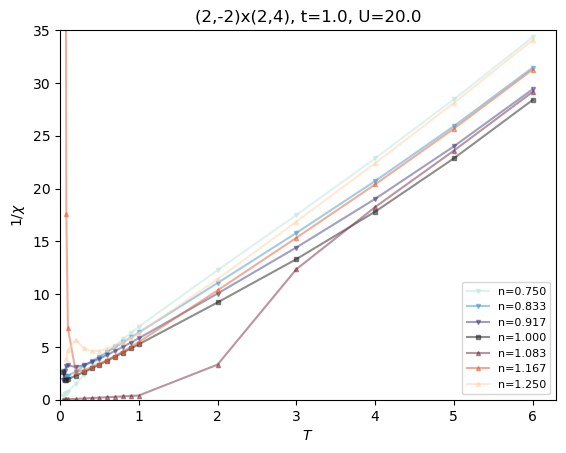

In [107]:
temperatures = unique(sort(df[:, :temperature]))
temperatures = [T for T in temperatures]
;

fig = PyPlot.figure()
ax = fig.gca()

# n_list = [5,6,7,8,9,10,11,12,13]
# n_list = [9,10,11,12,13,14,15]
n_list = n_sites-3:n_sites+3

for (idx, n) in enumerate(n_list)
    if n == 0 || n == 18
        continue
    end
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        
        
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2/T)
        end
    end
    
    if n > n_sites
        m = "^"
    elseif n == n_sites
        m = "s"
    else
        m = "v"
    end
    
    ax.plot(xs, n_sites ./ ys, linestyle="-", marker=m, label=(@sprintf "n=%.3f" (n/n_sites)),
        color=cmap((idx-1) / (length(n_list)-1)), alpha=0.5, markersize=3)
end
ax.set_xlim(0, nothing)
ax.set_ylim(0, 35)
ax.legend(fontsize=8)
ax.set_xlabel(raw"$T$")
ax.set_ylabel(raw"$1/\chi$")
ax.set_title("$(shape_str), t=$t, U=$U")
fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)

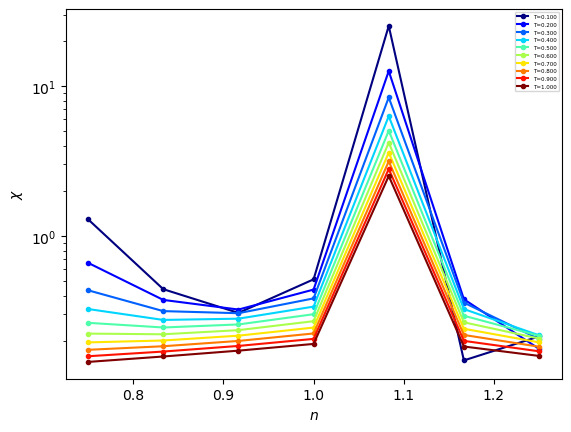

In [91]:
temperatures = unique(sort(df[:, :temperature]))
temperatures = [T for T in temperatures if 0.1 <= T <= 1.0]

fig = PyPlot.figure()
ax = fig.gca()
for T in temperatures
    sdf = df[df[:, :temperature] .== T, :]
    xs = Float64[]
    ys = Float64[]
    for n in n_list
        ssdf = sdf[sdf[:, :nup] .+ sdf[:, :ndn] .== n, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, n)
            push!(ys, corr - Sz_avg^2/T)
        end
    end
#     ax.plot(xs, 1 ./ ys, ".-", label=(@sprintf "n=%.3f" (n/9)))
    ax.plot(xs ./ n_sites, ys ./ n_sites, ".-",
        label=(@sprintf "T=%.3f" T),
        color=mpl.cm.jet( (T - minimum(temperatures)) / (maximum(temperatures) - minimum(temperatures))
    ))
end
# ax.set_xlim(0, nothing)
# ax.set_ylim(0, 1)
ax.legend(fontsize=4)
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$\chi$")
ax.set_yscale("log")

In [98]:
@. model(x, p) = p[1]*(x - p[2])

model (generic function with 1 method)

In [99]:
temperatures = unique(sort(df[:, :temperature]))
fit_temperatures = [T for T in temperatures if 2 <= T <= 4]

3-element Vector{Float64}:
 2.0
 3.0
 4.0

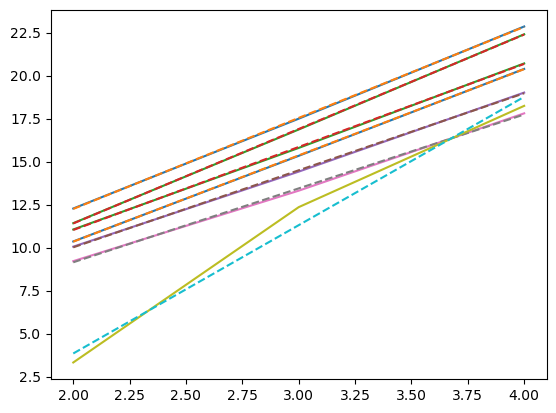

In [100]:
fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in fit_temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end
    f = curve_fit(model, xs, ys, [1.0, 0.0])
    PyPlot.plot(xs, ys)
    PyPlot.plot(xs, model(xs, f.param), "--")
    push!(fit_params, [n, f.param[2]] )
end

In [101]:
fit_params = hcat(fit_params...)

2×7 Matrix{Float64}:
  9.0       10.0       11.0       12.0       13.0      14.0        15.0
 -0.315082  -0.283983  -0.236302  -0.129298   1.48441  -0.0627484  -0.0772648

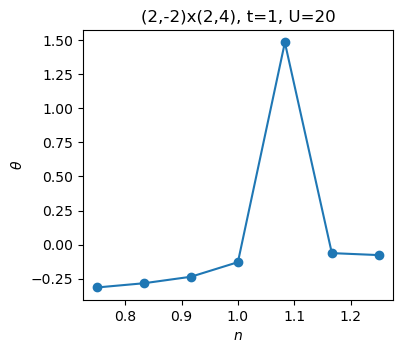

In [106]:
PyPlot.figure(figsize=(4, 3.5))
PyPlot.plot(fit_params[1,:] ./ n_sites, fit_params[2,:], "o-")
PyPlot.title("$shape_str, t=1, U=20")
PyPlot.xlabel(raw"$n$")
PyPlot.ylabel(raw"$\theta$")
PyPlot.savefig("weiss-triangular-$(shape_str)_t=$(t)_U=$(U).png", bbox_inches="tight")